# Auto-generate travel blogs 

In [1]:
'''Example script to generate blogging text from nomadic matt's blog.

Starting off by training a simple model with very little text
'''

from __future__ import print_function

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten, Dropout, TimeDistributed
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from matplotlib import pyplot
import seaborn as sns
import numpy as np
import pandas as pd
import random
import sys
import io
import re

from collections import Counter

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Download over a network
# path = get_file('output.txt', origin='https://www......')
# with io.open(path, encoding='utf-8') as f:
#     text = f.read().lower()

text = ''
with open("blog.txt", 'r') as content_file:
    for line in content_file.readlines():
        text += line

## Data preprocessing

In [3]:
def print_stats(text, chars):
    print('Total raw text chars:', len(text))    
    print('total vocab:', len(chars))
    print(chars)
    
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6654892
total vocab: 155
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '£', '®', '°', '±', '´', '¼', '½', 'Á', 'Å', 'Ç', 'É', 'Í', 'Î', '×', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ø', 'ú', 'û', 'ü', 'ý', 'ā', 'ī', 'ı', 'ş', 'š', '́', '–', '—', '‘', '’', '“', '”', '…', '″', '€', '✓', '😉', '🙁', '🙂']


The total vocab for this text comes to about 75 unique characters. Most of them are not required and can be removed. We shall cleanup the text to retain only ASCII characters and convert all alphabets to lowercase, which reduces the text size and brings down the vocab count.

In [4]:
def get_ASCII_text(text):
    return re.sub(r'[^\x00-\x7F]+','', text)

text = get_ASCII_text(text).lower()
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6614263
total vocab: 69
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


You can see that there are some more characters that we could remove to further clean up the dataset that will reduce the vocabulary and may improve the modeling process.

In [5]:
chars_to_remove = ['&', '[', ']', '\\', '^', '_', '`', '{', '}', '~', "'", '/', '\n']

for ch in chars_to_remove:
    if ch in text:
        text = text.replace(ch, '')
        
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6510373
total vocab: 57
[' ', '!', '"', '#', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']


To prepare data for modelling by the neural network, we cannot model the characters directly. We should first convert the characters to integers. This can be done by mapping every character to an integer. 

Also, when preparing the mapping of unique characters to integers, we must also create a reverse mapping that we can use to convert the integers back to characters so that we can understand the predictions.

In [6]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

We now need to define the training data for the network. There is a lot of flexibility in how we choose to break up the text and expose it to the network during training.
We shall split the blog text into subsequences of 40 characters. We shall slide this window of 100 characters along the entire blog text, jumping 3 characters at every stride.

In [7]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 2170111


## Visualization

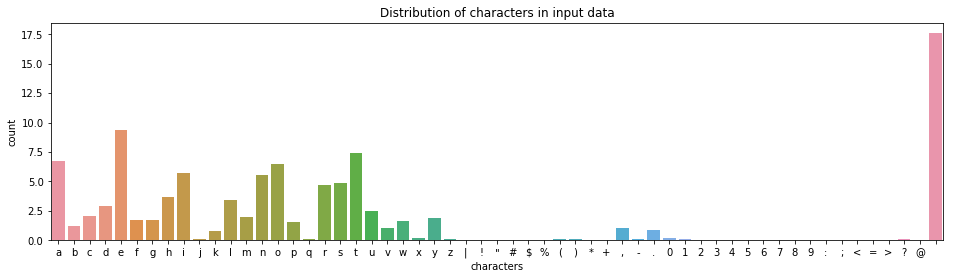

In [8]:
text_len = len(text)

char_frequency_counter = Counter()
char_frequency_counter += Counter(text)

char_frequency_dataframe = pd.DataFrame.from_dict(char_frequency_counter, orient='index').reset_index()
char_frequency_dataframe = char_frequency_dataframe.rename(columns={'index':'characters', 0:'count'})
order_of_chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','|', '!', '"', '#', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', ' ']

pyplot.figure(figsize=(16,4))
pyplot.title('Distribution of characters in input data')
pyplot.ylabel('Frequency [%]')
ax = sns.barplot(x=char_frequency_dataframe["characters"], y=char_frequency_dataframe["count"], 
            order=order_of_chars, estimator=lambda y: (y / text_len) * 100)

## One-hot encoding

First we must transform the list of input sequences into the form [samples, time steps, features] expected by an LSTM network. Next we need to rescale the integers to the range 0-to-1 to make the patterns easier to learn by the LSTM network that uses the sigmoid activation function by default. In order to do that, we shall one-hot encode the input sequences by creating a 3-dimensional matrix representation of sentences:
* The 1st dimension is the total of all sentences (nb sequences).
* The 2nd dimension is the length of each sentence, in our case 40
* The 3rd dimension is the length of total vocab/unique characters, in our case 59.

The output consists of a one-hot encoded 2-dimensional matrix. 
* The 1st dimension remains the same as input.
* The 2nd dimension has the length of total vocab/unique characters.

The output pair tells the next char for every input pair.

In [9]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print("Total patterns", len(x))
print("Input vector shape", x.shape)
print("Output vector shape", y.shape)

Vectorization...
Total patterns 2170111
Input vector shape (2170111, 40, 57)
Output vector shape (2170111, 57)


## Building and running the model

In [10]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(32, input_shape=(x.shape[1], x.shape[2]))) #, return_sequences=True))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

In [11]:
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

optimizer = 'adam'# RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[perplexity])

In [12]:
# Add a model checkpoint
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

### Generating Text with an LSTM Network

The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. This process is repeated for as long as we want to predict new characters (e.g. a sequence of 400 characters in length).

We can pick a random input pattern as our seed sequence, then print generated characters as we generate them.

In [13]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [14]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [15]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

result = model.fit(x, y,
          batch_size=32,
          epochs=10,
          validation_split=0.20,
          callbacks=[print_callback, checkpoint])

Train on 1736088 samples, validate on 434023 samples
Epoch 1/10
1736032/1736088 [============================>.] - ETA: 0s - loss: 2.1180 - perplexity: 22113.8442
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "in hostels, you should still consider dr"
in hostels, you should still consider dravel and the the some a for the way and the some and the compers and the compers and the mant and a way the promed in the part and a travel and the the was the way a for the some to the sear a for the and the comple the some the and and the some the long the was the a the the the prome and a the some the be a the a the mant and a the pars and a the some the pars and a the was the perser in the was
----- diversity: 0.5
----- Generating with seed: "in hostels, you should still consider dr"
in hostels, you should still consider dravel sears do this ever the sime all a ways the way to to the ports on the mone coms at a with the trip and and in a it a part of the k

l parents, or an upper-class upbringing the been the stall have the month the shour the was the site the bean the been the bean the was a procas the start in the bean the was a place the can a prover the started the country to destination the country to the was the bean i stay and the bean and the bean and a was the been the been in the bean and the stay and start the country the start the start the procal and the country the been the w
----- diversity: 0.5
----- Generating with seed: "l parents, or an upper-class upbringing "
l parents, or an upper-class upbringing lookers and life the the far and the good to the country to of the are i start the been the the here in the make in the want there and the get a decan i can in the but i an and and just work and have some its the sechind what the beant can been i have and the the thing the west in the dring in a sise from the were i hours and the come the people and the rears to are the the deain of the stan that 
----- diversity: 1.0
-----

 there are a lot more incredibly breaththais. when of not that and a fander the start to way for do the practive in the was the lack to the the best on the with a fimall food the loter a few hate way, the the comment the started to see was the that you have the that me the contred breat the every dont have the can the to the deasions and the some the country to mach the some to do one had offer a do a life of the in more out the past of
----- diversity: 1.0
----- Generating with seed: " there are a lot more incredibly breatht"
 there are a lot more incredibly breathth commoras to orlendice how, will lack around exerne treast dilo hest there are quest find a withers, get just when, the an, litt with a kanine theson mening by go in much thooknts part. the ploose all loch but come-mermich the monthie varisty fell they are great you qurot to tribs to quiol on 110im wrated lyn railen day and this sturmacts.so marke the sliengrone anyifital on blagheling out, and w
----- diversity: 1.2
-----

/home/vandy/anaconda3/envs/blog-bot/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


avel of the the south and the to do the dont start and the the country to the some to deed and the because the country to do you be to some the something the south and a started to stay the to be to stay to travel and the to the month and the south and the country to save the started the more to the site th
----- diversity: 0.5
----- Generating with seed: "s to say, i had low expectations.but im "
s to say, i had low expectations.but im last even the the world place travel and many create viewning on the in the to conting all the money. the rood started travel proply here to really become a loter to will the new for travel of the trip of the dont a group tople out in the and the book on the money in the state the resword of the world and and somethere the of the stay to save more the beares and anct sare to some are your with pac
----- diversity: 1.0
----- Generating with seed: "s to say, i had low expectations.but im "
s to say, i had low expectations.but im fast, in filly recarmage a

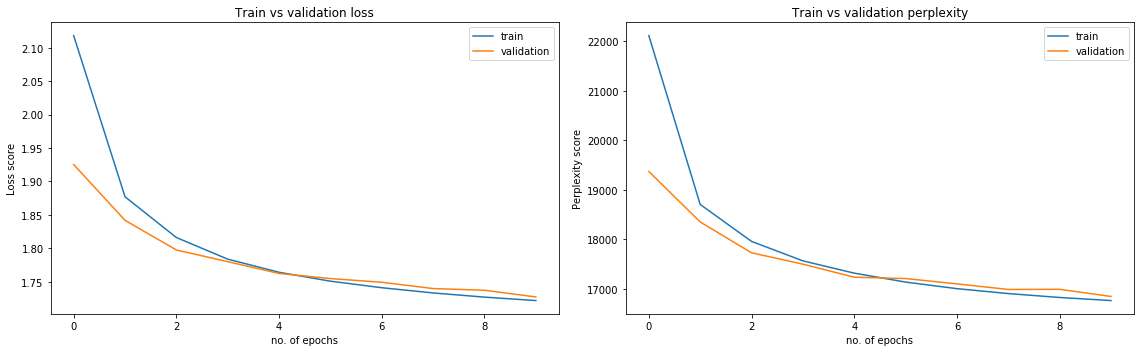

In [16]:
pyplot.figure(figsize=(16,5))


# sp1
pyplot.subplot(121)
pyplot.plot(result.history["loss"])
pyplot.plot(result.history["val_loss"])
pyplot.title('Train vs validation loss')
pyplot.xlabel('no. of epochs')
pyplot.ylabel('Loss score')
pyplot.legend(['train', 'validation'], loc='upper right')

# sp2
pyplot.subplot(122)
pyplot.plot(result.history["perplexity"])
pyplot.plot(result.history["val_perplexity"])
pyplot.title('Train vs validation perplexity')
pyplot.xlabel('no. of epochs')
pyplot.ylabel('Perplexity score')
pyplot.legend(['train', 'validation'], loc='upper right')

pyplot.tight_layout()

pyplot.show()